In [1]:
import sys
# If you want to re-run, just modify this to where you put the NS_NFMC fork of the PyMC3 repo.
sys.path.insert(1, '/home/richard/pymc3_dev/')
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

print(f"Running on PyMC3 v{pm.__version__}")

az.style.use("arviz-darkgrid")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Running on PyMC3 v3.11.0


In [2]:
n = 4

mu1 = np.ones(n) * (1.0 / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.3  # one mode with 0.1 of the mass 
w2 = 1 - w1  # the other mode with 0.9 of the mass

def two_gaussians(x):
    log_like1 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return pm.math.logsumexp([tt.log(w1) + log_like1, tt.log(w2) + log_like2])

with pm.Model() as model:
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-2.0 * np.ones_like(mu1),
        upper=2.0 * np.ones_like(mu1),
        testval=-1.0 * np.ones_like(mu1),
    )
    llk = pm.Potential("llk", two_gaussians(X))
    trace, nf_models, importance_weights = pm.sample_nfmc(500, optim_iter=1000, nf_iter=10, chains=1,
                                                          frac_validate=0.2, alpha=(0.5,0.5), parallel=False)
    az_trace = az.from_pymc3(trace)

Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(


Running initial optimization ...
Fitting the first NF approx to the prior optimized samples ...


Stage:   1
Stage:   2
Stage:   3
Stage:   4
Stage:   5
Stage:   6
Stage:   7
Stage:   8
Stage:   9
Stage:  10


<Figure size 720x480 with 0 Axes>

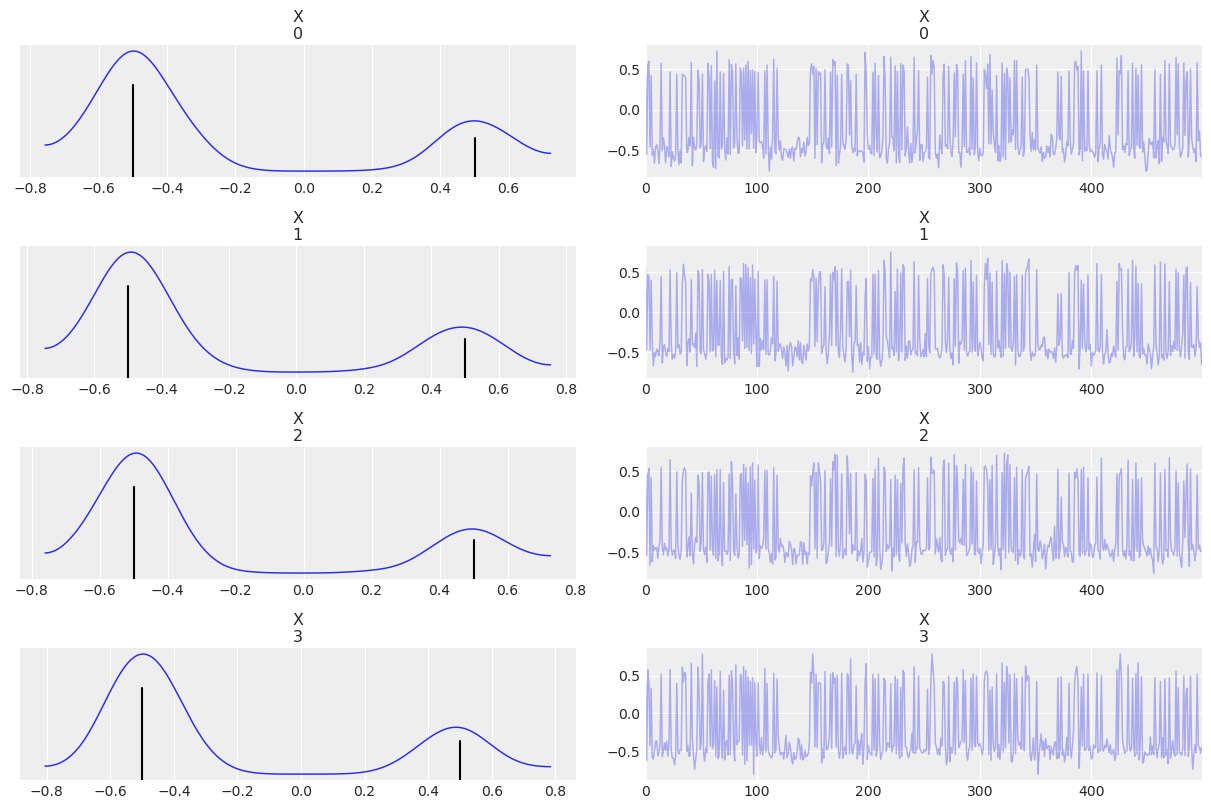

In [3]:
plt.figure()
ax = az.plot_trace(az_trace, compact=False)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

In [4]:
rg_model = pm.Model()
x = np.arange(10)
y = 2 * x + 1 + np.random.normal(scale=0.1)

with rg_model:

    a = pm.Normal('a', mu=2, sigma=1)
    b = pm.Normal('b', mu=1, sigma=1)

    like = pm.Normal('like', mu=a*x+b, sigma=0.1, observed=y)
    trace, nf_models, importance_weights = pm.sample_nfmc(500, optim_iter=1000, nf_iter=10, chains=1,
                                                          frac_validate=0.2, alpha=(0.5,0.5), parallel=False)
    az_trace = az.from_pymc3(trace)

Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


Running initial optimization ...
Fitting the first NF approx to the prior optimized samples ...


Stage:   1
Stage:   2
Stage:   3
Stage:   4
Stage:   5
Stage:   6
Stage:   7
Stage:   8
Stage:   9
Stage:  10


<Figure size 720x480 with 0 Axes>

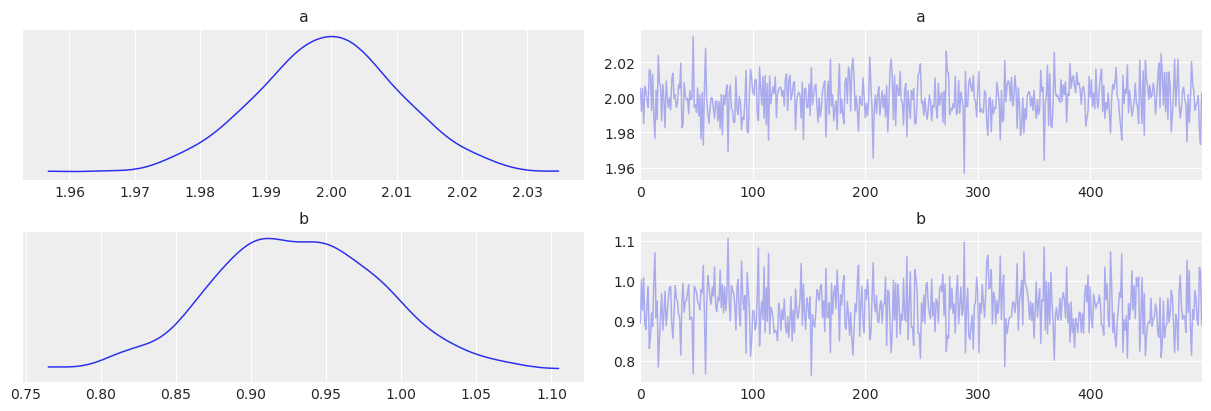

In [5]:
plt.figure()
ax = az.plot_trace(az_trace)
plt.show()